In [33]:
# Import necessary libraries 
import pandas as pd
import re
import spacy
from collections import Counter
from nltk import ngrams
import pickle
import numpy as np
import gensim.downloader as api

In [34]:
# Download necessary data
import spacy.cli
spacy.cli.download('en_core_web_sm') # Download English model

# Load the IMDB dataset
df = pd.read_csv('IMDB Dataset.csv')
print(df.head())
print(df.shape)
print(df.isnull().sum())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(50000, 2)
review       0
sentiment    0
dtype: int64


In [35]:
# Clean and preprocess the raw data
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # Load spacy without unnecessary components (for this project) for efficiency

# Preprocessing function to clean reviews
def preprocess_dataset(texts):
    cleaned_texts = []
    docs = list(nlp.pipe(texts, batch_size=1000))
    for doc in docs:
        # Collect lemmas for valid tokens in this doc
        cleaned = [token.lemma_ for token in doc if not token.is_stop and (token.is_alpha or token.is_digit)]
        # Join into a single string per review
        cleaned_texts.append(' '.join(cleaned))
    return cleaned_texts

# Apply preprocessing to the reviews
df['cleaned_review'] = preprocess_dataset(df['review'])
print(df[['review', 'cleaned_review']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  reviewer mention watch 1 Oz episode hook right...  
1  wonderful little production br filming techniq...  
2  think wonderful way spend time hot summer week...  
3  basically family little boy Jake think zombie ...  
4  Petter Mattei love Time money visually stunnin...  


In [36]:
# Generate n-grams from cleaned text
def generate_ngrams(text, n=2):
    words = text.split()
    return list(ngrams(words, n))

# Apply n-gram generation (bigrams)
df['bigrams'] = df['cleaned_review'].apply(lambda x: generate_ngrams(x, 2))
print(df[['cleaned_review', 'bigrams']].head())

                                      cleaned_review  \
0  reviewer mention watch 1 Oz episode hook right...   
1  wonderful little production br filming techniq...   
2  think wonderful way spend time hot summer week...   
3  basically family little boy Jake think zombie ...   
4  Petter Mattei love Time money visually stunnin...   

                                             bigrams  
0  [(reviewer, mention), (mention, watch), (watch...  
1  [(wonderful, little), (little, production), (p...  
2  [(think, wonderful), (wonderful, way), (way, s...  
3  [(basically, family), (family, little), (littl...  
4  [(Petter, Mattei), (Mattei, love), (love, Time...  


In [38]:
# Load pre-trained GloVe word embeddings
model = api.load("glove-wiki-gigaword-100")

# Split df to avoid data leakage
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.15, stratify=df['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.176, stratify=temp_df['sentiment'], random_state=42)  # ~15% val from remaining

print("Data split complete.")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Prepare data for neural network using pretrained GloVe embeddings (vocab from train only)

# Use cleaned_review without special tokens
train_df['label'] = train_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
val_df['label'] = val_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
test_df['label'] = test_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Define special tokens for sequence modeling
special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']

# Get all unique words from train_df only
all_words = set()
for review in train_df['cleaned_review']:
    words = review.split()
    all_words.update(words)

# The vocabulary contains all the necessary words and tokens for the embeddings (from train)
vocab = special_tokens + list(all_words)
vocab_size = len(vocab)

# Every word should be assigned with an index for vectorization 
word_to_index = {word: i for i, word in enumerate(vocab)}

# Create embedding matrix (from train vocab)
embedding_dim = 100
# vocab size (x) x embedding dimensions (y) 
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# The embedding matrix has all the words that exist in both the vocabulary of the train dataset and pre-trained model
for word, i in word_to_index.items():
    if word in model and word not in special_tokens:
        # Returns vector with 100 values
        embedding_matrix[i] = model[word]

# Function to create sequences
def create_sequences(reviews, word_to_index):
    X = []
    for review in reviews:
        # Assigns index of SOS to begin and if a word doesnt exist it assigns index of UNK and in the end EOS 
        seq = [word_to_index['<SOS>']] + [word_to_index.get(word, word_to_index['<UNK>']) for word in review.split()] + [word_to_index['<EOS>']]
        X.append(seq)
    max_len = max(len(seq) for seq in X) if X else 0
    X = np.array([seq + [word_to_index['<PAD>']] * (max_len - len(seq)) for seq in X])
    return X

# Convert to sequences for train, val, test
X_train = create_sequences(train_df['cleaned_review'], word_to_index)
X_val = create_sequences(val_df['cleaned_review'], word_to_index)
X_test = create_sequences(test_df['cleaned_review'], word_to_index)

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

all_seqs = [seq for seqs in [X_train, X_val, X_test] for seq in seqs]
max_len = max(len(seq) for seq in all_seqs) if all_seqs else 0

# Pad all sequences to the global max_len
def pad_to_max_len(X, max_len, pad_idx):
    result = []
    for seq in X:
        if len(seq) < max_len:
            pads = np.full(max_len - len(seq), pad_idx, dtype=seq.dtype)
            result.append(np.concatenate([seq, pads]))
        else:
            result.append(seq)
    return np.array(result)

X_train = pad_to_max_len(X_train, max_len, word_to_index['<PAD>'])
X_val = pad_to_max_len(X_val, max_len, word_to_index['<PAD>'])
X_test = pad_to_max_len(X_test, max_len, word_to_index['<PAD>'])

# Save preprocessing artifacts
with open('neural_preprocessing.pkl', 'wb') as f:
    pickle.dump({
        'word_to_index': word_to_index,
        'embedding_matrix': embedding_matrix,
        'max_len': max_len,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }, f)

print("Neural preprocessing complete. Data saved for model training.")

Data split complete.
Training set size: 42500
Validation set size: 6180
Test set size: 1320
Neural preprocessing complete. Data saved for model training.


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load preprocessed data
with open('neural_preprocessing.pkl', 'rb') as f:
    data = pickle.load(f)
    word_to_index = data['word_to_index']
    embedding_matrix = data['embedding_matrix']
    max_len = data['max_len']
    X_train = data['X_train']
    X_val = data['X_val']
    X_test = data['X_test']
    y_train = data['y_train']
    y_val = data['y_val']
    y_test = data['y_test']

print("Data loaded.")
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")
print(f"Input shape: {X_train.shape}")

# Convert to tensors
X_train = torch.from_numpy(X_train).long() 
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).long()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).long()
y_test = torch.from_numpy(y_test).float()

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data loaded.
Training set size: 42500
Validation set size: 6180
Test set size: 1320
Input shape: (42500, 1298)


In [40]:
# Neural Model for Sentimantic Analysis
class SemanticClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout):
        super().__init__()
        weights = torch.as_tensor(embedding_matrix, dtype=torch.float)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        
        # Concatenated Mean + Max pooling = 2 * embedding_dim
        input_dim = weights.shape[1] * 2 
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(), # Better gradient flow than ReLU
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).unsqueeze(-1).float()
        
        # Masked Mean Pooling
        mean_pooled = (embedded * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        # Masked Max Pooling (set padding to very low value)
        max_pooled, _ = torch.max(embedded * mask + (1 - mask) * -1e9, dim=1)
        
        # Combine both to capture average sentiment AND peak signals
        combined = torch.cat([mean_pooled, max_pooled], dim=1)
        return self.net(combined).squeeze()

# Implement GRU and LSTM to compare them with the other neural and classical approaches

# Optimized RNN Base (Used for both GRU and LSTM)
class OptimizedRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="GRU"):
        super().__init__()
        weights = torch.as_tensor(embedding_matrix, dtype=torch.float)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        
        # Added Bidirectionality (looks at context from both ends)
        # Added Multiple Layers
        RNN_Class = nn.GRU if rnn_type == "GRU" else nn.LSTM
        self.rnn = RNN_Class(
            weights.shape[1], 
            hidden_dim, 
            num_layers=1, 
            bidirectional=True, 
            batch_first=True, 
            dropout=0
        )
        
        # Input is hidden_dim * 2 (bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        
        # Use torch.sum on current device
        lengths = (x != 0).sum(dim=1).to(torch.int64).cpu() 
        
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )
        
        # Use full output instead of just hidden state
        packed_output, _ = self.rnn(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Global Max Pooling over time: Captures the most important feature found in the sequence
        pooled, _ = torch.max(output, dim=1)
        
        return self.fc(pooled).squeeze()


class RNNwAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="GRU"):
        super().__init__()
        weights = torch.as_tensor(embedding_matrix, dtype=torch.float)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False)

        RNN_Class = nn.GRU if rnn_type == "GRU" else nn.LSTM
        self.rnn = RNN_Class(
            weights.shape[1], 
            hidden_dim, 
            num_layers=1, 
            bidirectional=True, 
            batch_first=True, 
            dropout=0
        )        

        # Attention layer: linear projection for attention scores
        self.attention = nn.Linear(hidden_dim * 2, 1) # hidden_dim * 2 due to bidirectionality

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        embedded = self.embedding(x)
        lengths = (x != 0).sum(dim=1).to(torch.int64).cpu() 
        
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )
        packed_output, _ = self.rnn(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Attention mechanism
        att_scores = self.attention(output).squeeze(-1)  # (batch, seq_len_batch_max)
        # Create mask based on actual lengths
        mask = torch.arange(output.size(1)).unsqueeze(0).to(x.device) < lengths.unsqueeze(1).to(x.device)  # (batch, seq_len_batch_max)
        att_scores = att_scores.masked_fill(mask == 0, -1e9)  # Use -1e9 to ignore padding in softmax
        att_weights = torch.softmax(att_scores, dim=1).unsqueeze(-1)  # (batch, seq_len_batch_max, 1)
        attended = (output * att_weights).sum(dim=1)  # (batch, hidden_dim * 2)
        
        return self.fc(attended).squeeze(), att_weights.squeeze(-1)  # Return att_weights as (batch, seq_len_batch_max) for consistency
        

# GRU approach (faster, simpler)
class SemanticClassifierGRU(OptimizedRNN):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout):
        super().__init__(embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="GRU")

# LSTM approach (more reliable)
class SemanticClassifierLSTM(OptimizedRNN):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout):
        super().__init__(embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="LSTM")

# GRU approach with Attention 
class AttwSemanticClassifierGRU(RNNwAttention):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout):
        super().__init__(embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="GRU")

# LSTM approach with Attention
class AttwSemanticClassifierLSTM(RNNwAttention):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout):
        super().__init__(embedding_matrix, hidden_dim, output_dim, dropout, rnn_type="LSTM")

In [ ]:
from sklearn.metrics import f1_score
import json
import random
from itertools import product

def train_and_evaluate_model(model_class, embedding_matrix, train_loader, val_loader, test_loader, lr=0.001, weight_decay=1e-3, hidden_dim=64, dropout=0.5):
    model = model_class(embedding_matrix, hidden_dim=hidden_dim, output_dim=1, dropout=dropout)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # LR decay
    criterion = nn.BCEWithLogitsLoss()  # More stable
    patience = 0
    best_val_f1 = 0  # Track best val F1 for early stopping

    # Training with 20 epochs
    epochs = 20

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_X)
            if isinstance(output, tuple):
                output = output[0]  # Unpack for attention models
            loss = criterion(output, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        
        scheduler.step()  # Update LR
        
        # Validation on val_loader
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                val_output = model(batch_X)
                if isinstance(val_output, tuple):
                    val_output = val_output[0]  # Unpack for attention models
                loss = criterion(val_output, batch_y)
                val_loss += loss.item()
                preds = (val_output > 0).int()  # Note: > 0 since logits, not probs
                all_preds.extend(preds.numpy())
                all_labels.extend(batch_y.int().numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, zero_division=0)
        rec = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
        print(f"Epoch {epoch+1}: Train Loss {train_loss/len(train_loader):.4f}, Val Loss {val_loss/len(val_loader):.4f}, Acc {acc:.4f}, Prec {prec:.4f}, Rec {rec:.4f}, F1 {f1:.4f}")

        # Early stopping based on val F1
        if f1 > best_val_f1:
            best_val_f1 = f1
            patience = 0
        else:
            patience += 1
            if patience >= 2:
                break
    
    return model, best_val_f1

def tune_hyperparameters(model_class, embedding_matrix, train_loader, val_loader, test_loader):
    param_space = {
        'lr': [0.001, 0.0005],
        'weight_decay': [1e-3, 1e-2],
        'dropout': [0.3, 0.5],
        'hidden_dim': [32, 64]
    }
    
    # Generate all possible combinations
    all_combos = list(product(
        param_space['lr'],
        param_space['weight_decay'],
        param_space['dropout'],
        param_space['hidden_dim']
    ))
    
    # Randomly sample 5 combinations
    sampled_combos = random.sample(all_combos, 5)
    
    best_val_f1 = 0
    best_params = None
    best_model_state = None
    for combo in sampled_combos:
        lr, wd, drop, hd = combo
        print(f"Trying lr={lr}, wd={wd}, dropout={drop}, hidden_dim={hd}")
        model, val_f1 = train_and_evaluate_model(model_class, embedding_matrix, train_loader, val_loader, test_loader, lr=lr, weight_decay=wd, hidden_dim=hd, dropout=drop)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_params = {'lr': lr, 'weight_decay': wd, 'hidden_dim': hd, 'dropout': drop}
            best_model_state = model.state_dict()
    torch.save(best_model_state, f'best_{model_class.__name__}.pth')
    with open(f'best_{model_class.__name__}_params.json', 'w') as f:
        json.dump(best_params, f)
    return best_val_f1, best_params

# Train and compare all models without Attention
results = {}
models = [SemanticClassifier, SemanticClassifierGRU, SemanticClassifierLSTM]

for model_class in models:
    print(f"\nTuning hyperparameters for {model_class.__name__}...")
    best_val_f1, best_params = tune_hyperparameters(model_class, embedding_matrix, train_loader, val_loader, test_loader)
    results[model_class.__name__] = {'val_f1': best_val_f1, 'best_params': best_params}

print("\nEvaluating non-attention models on test set:")
for name, data in results.items():
    best_params = data['best_params']
    model_class = globals()[name]
    model = model_class(embedding_matrix, hidden_dim=best_params['hidden_dim'], dropout=best_params['dropout'], output_dim=1)
    model.load_state_dict(torch.load(f'best_{name}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            output = model(batch_X)
            if isinstance(output, tuple):
                output = output[0]
            preds = (output > 0).int()
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.int().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    data['test_acc'] = acc
    data['test_prec'] = prec
    data['test_rec'] = rec
    data['test_f1'] = f1
    print(f"{name}: Acc {acc:.4f}, Prec {prec:.4f}, Rec {rec:.4f}, F1 {f1:.4f}")




Tuning hyperparameters for SemanticClassifier...
Trying lr=0.001, wd=0.001, dropout=0.5, hidden_dim=64
Epoch 1: Train Loss 0.3939, Val Loss 0.3177, Acc 0.8629, Prec 0.9302, Rec 0.7848, F1 0.8513
Epoch 2: Train Loss 0.2313, Val Loss 0.2658, Acc 0.8926, Prec 0.9033, Rec 0.8793, F1 0.8911
Epoch 3: Train Loss 0.1547, Val Loss 0.3372, Acc 0.8707, Prec 0.8224, Rec 0.9456, F1 0.8797
Epoch 4: Train Loss 0.0970, Val Loss 0.7335, Acc 0.8011, Prec 0.9528, Rec 0.6337, F1 0.7611
Trying lr=0.001, wd=0.001, dropout=0.5, hidden_dim=32
Epoch 1: Train Loss 0.4048, Val Loss 0.3103, Acc 0.8717, Prec 0.9215, Rec 0.8126, F1 0.8636
Epoch 2: Train Loss 0.2352, Val Loss 0.2710, Acc 0.8906, Prec 0.8737, Rec 0.9133, F1 0.8930
Epoch 3: Train Loss 0.1623, Val Loss 0.3111, Acc 0.8848, Prec 0.9157, Rec 0.8476, F1 0.8803
Epoch 4: Train Loss 0.1066, Val Loss 0.4366, Acc 0.8767, Prec 0.8424, Rec 0.9269, F1 0.8826
Trying lr=0.0005, wd=0.001, dropout=0.3, hidden_dim=64
Epoch 1: Train Loss 0.4286, Val Loss 0.3783, Acc 0.

In [ ]:
# Train and compare all models with Attention
results_att = {}
models_att = [AttwSemanticClassifierGRU, AttwSemanticClassifierLSTM]

for model_class in models_att:
    print(f"\nTuning hyperparameters for {model_class.__name__}...")
    best_val_f1, best_params = tune_hyperparameters(model_class, embedding_matrix, train_loader, val_loader, test_loader)
    results_att[model_class.__name__] = {'val_f1': best_val_f1, 'best_params': best_params}

print("\nEvaluating attention models on test set:")
for name, data in results_att.items():
    best_params = data['best_params']
    model_class = globals()[name]
    model = model_class(embedding_matrix, hidden_dim=best_params['hidden_dim'], dropout=best_params['dropout'], output_dim=1)
    model.load_state_dict(torch.load(f'best_{name}.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            output, _ = model(batch_X)  # Unpack for attention
            preds = (output > 0).int()
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_y.int().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    data['test_acc'] = acc
    data['test_prec'] = prec
    data['test_rec'] = rec
    data['test_f1'] = f1
    print(f"{name}: Acc {acc:.4f}, Prec {prec:.4f}, Rec {rec:.4f}, F1 {f1:.4f}")

# Find and save the overall best model
all_results = {**results, **results_att}
best_model_name = max(all_results, key=lambda x: all_results[x]['test_f1'])
best_data = all_results[best_model_name]

print(f"\nOverall best model: {best_model_name} with test F1: {best_data['test_f1']:.4f}")

# Save overall best model
model_class = globals()[best_model_name]
model = model_class(embedding_matrix, hidden_dim=best_data['best_params']['hidden_dim'], dropout=best_data['best_params']['dropout'], output_dim=1)
model.load_state_dict(torch.load(f'best_{best_model_name}.pth'))
torch.save(model.state_dict(), 'best_model.pth')

# Save hyperparameters
with open('best_model_params.json', 'w') as f:
    json.dump({'model_name': best_model_name, **best_data['best_params']}, f)

print("Best model saved as 'best_model.pth' and params as 'best_model_params.json'")

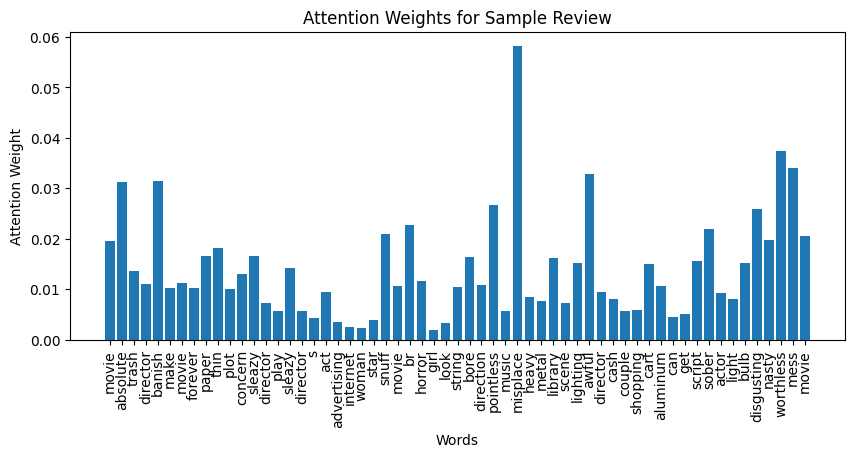

In [43]:
import matplotlib.pyplot as plt

# Visualize for a single test sample
# Use the best params for AttwSemanticClassifierLSTM
best_params_lstm = results_att['AttwSemanticClassifierLSTM']['best_params']
model = AttwSemanticClassifierLSTM(embedding_matrix, hidden_dim=best_params_lstm['hidden_dim'], dropout=best_params_lstm['dropout'], output_dim=1)
model.load_state_dict(torch.load('best_AttwSemanticClassifierLSTM.pth'))
model.eval()

# Get a sample from test_loader
sample_X, sample_y = next(iter(test_loader))
sample_X = sample_X[:1]  # Take first batch item

with torch.no_grad():
    output, att_weights = model(sample_X)
    att_weights = att_weights.squeeze(0).cpu().numpy()  # Shape: (seq_len,)

# Map back to words
seq = sample_X.squeeze(0).cpu().numpy() 
words = [list(word_to_index.keys())[i] for i in seq if i not in [0, 2, 3]]  # Exclude <PAD>, <SOS>, <EOS>, but include <UNK> and content words
# Attention weights correspond to positions 1 to 1+len(words)
att_weights_trimmed = att_weights[1:1+len(words)]  # Trim to match words

# Plot
plt.figure(figsize=(10, 4))
plt.bar(range(len(words)), att_weights_trimmed, tick_label=words)
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Attention Weight')
plt.title('Attention Weights for Sample Review')
plt.show()